# 5.3 Truncated BPTT

Course's materials require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

 

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

When the sequences are very long (thousands of points), the network training can be very slow and the memory requirements increase. The truncated BPTT is an alternative similar to mini-batch training in Dense Networks, even though in RNN the batch parameter can also be used. 

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

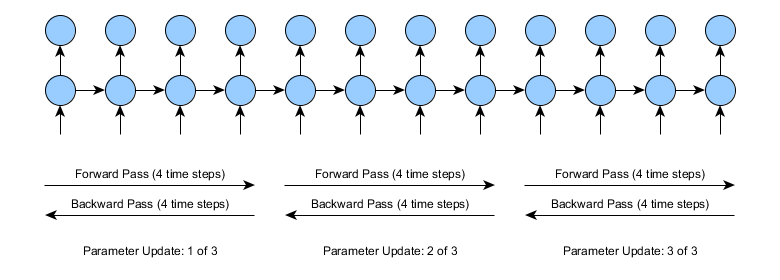

In [1]:
from IPython.display import Image
Image(filename='local/imgs/rnn_tbptt_2.png', width=1200)
#![alt text](local/imgs/rnn_tbptt_2.png "Truncated BPTT")

The TBPTT can be implemented by setting up the data appropriately. Let's remember that for recurrent neural networks, data must have the format **[n_samples,n_times,n_features]**, so if you want to use Truncated BPTT you just have to split the sequences into more **n_samples** of less **n_times**. 

### **BUT**, **Is it possible that the LSTM may find dependencies between the sequences?**

No it’s not possible unless you go for the stateful LSTM.

So the use of Truncated BPTT requires to set up the **Stateful** mode.

## Example

Extracted from: http://philipperemy.github.io/keras-stateful-lstm/

Let’s see a problem of classifying sequences. The data matrix $X$ is made exclusively of zeros except in the first column where exactly half of the values are 1.

In [1]:
import numpy as np
from numpy.random import choice
N_train = 1000
X_train = np.zeros((N_train,20))
one_indexes = choice(a=N_train, size=int(N_train / 2), replace=False)
X_train[one_indexes, 0] = 1  # very long term memory.
#--------------------------------
N_test = 200
X_test = np.zeros((N_test,20))
one_indexes = choice(a=N_test, size=int(N_test / 2), replace=False)
X_test[one_indexes, 0] = 1  # very long term memory.
print(X_train[:10,:5])
print(X_test[:10,:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [2]:
print(X_train.shape)

(1000, 20)


In [3]:
def prepare_sequences(x_train, y_train, window_length, increment):
    windows = []
    windows_y = []
    for i, sequence in enumerate(x_train):
        len_seq = len(sequence)
        for window_start in range(0, len_seq - window_length + 1, increment):
            window_end = window_start + window_length
            window = sequence[window_start:window_end]
            windows.append(window)
            windows_y.append(y_train[i])
    return np.array(windows), np.array(windows_y)

In [4]:
#Split the sequences into two sequences of length 10
window_length = 10

x_train, y_train = prepare_sequences(X_train, X_train[:,0], window_length,window_length)
x_test, y_test = prepare_sequences(X_test, X_test[:,0], window_length,window_length)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2000, 10, 1)
(2000, 1)
(400, 10, 1)
(400, 1)


Every sequence was split into 2 subsequences

In [5]:
print(x_train[:4,:])
print(y_train[:4,:])

[[[1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]
[[1.]
 [1.]
 [0.]
 [0.]]


### Let's train a regular LSTM network

In [6]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [7]:
#Para resolver problema de compatibilidad tf 2.4 con algunas GPUs
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Using the original sequences:

In [8]:
print('Building STATELESS model...')
max_len = 10
batch_size = 11
model = Sequential()
model.add(LSTM(10, input_shape=(20, 1), return_sequences=False, stateful=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train.reshape(1000,20,1), X_train[:,0].reshape(1000,1), batch_size=batch_size, epochs=5,
          validation_data=(X_test.reshape(200,20,1), X_test[:,0].reshape(200,1)), shuffle=False)
score, acc = model.evaluate(X_test.reshape(200,20,1),X_test[:,0].reshape(200,1), batch_size=batch_size, verbose=0)

Building STATELESS model...
Epoch 1/5
91/91 [==============================] - 3s 6ms/step - loss: 0.6856 - accuracy: 0.5882 - val_loss: 0.3346 - val_accuracy: 1.0000
Epoch 2/5
91/91 [==============================] - 0s 2ms/step - loss: 0.2117 - accuracy: 1.0000 - val_loss: 0.0778 - val_accuracy: 1.0000
Epoch 3/5
91/91 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 4/5
91/91 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 5/5
91/91 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000


In [9]:
acc

1.0

### Using the splitted sequences:

In [10]:
print('Building STATELESS model...')
max_len = 10
batch_size = 2
model = Sequential()
model.add(LSTM(10, input_shape=(max_len, 1), return_sequences=False, stateful=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=15,
          validation_data=(x_test, y_test), shuffle=False)
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)

Building STATELESS model...
Epoch 1/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5768 - accuracy: 0.7036 - val_loss: 0.4794 - val_accuracy: 0.7500
Epoch 2/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4783 - accuracy: 0.7574 - val_loss: 0.4785 - val_accuracy: 0.7500
Epoch 3/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4774 - accuracy: 0.7574 - val_loss: 0.4782 - val_accuracy: 0.7500
Epoch 4/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4771 - accuracy: 0.7574 - val_loss: 0.4780 - val_accuracy: 0.7500
Epoch 5/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4769 - accuracy: 0.7574 - val_loss: 0.4779 - val_accuracy: 0.7500
Epoch 6/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4767 - accuracy: 0.7574 - val_loss: 0.4779 - val_accuracy: 0.7500
Epoch 7/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4766 - accuracy: 0.7574 - val_

In [11]:
acc

0.75

The sequences composed of 0s are correctly classified. The subsequences starting with 1 are correctly classified, but the sebsequences of class 1 starting with 0, are wrong classified. Those are the 25% of the sequences.

### What happened?

The long range memory required to classify the sequences correctly has been lost because of the sequences' partition. 

### STATEFUL Model

In [12]:
print('Build STATEFUL model...')
max_len = 10
n_partitions = 2
batch = 1
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch, max_len, 1), return_sequences=False, stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Build STATEFUL model...


In [13]:
print('Train...')

for epoch in range(5):
    mean_tr_acc = []
    mean_tr_loss = []
    for i in range(0,x_train.shape[0],n_partitions):
        #print(i)
        for j in range(n_partitions):
            #print(j)
            tr_loss, tr_acc = model.train_on_batch(x_train[i+j,:,:].reshape(1,max_len,1), y_train[i+j,:].reshape(1,1))
            mean_tr_acc.append(tr_acc)
            mean_tr_loss.append(tr_loss)
        model.reset_states()    
    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')

    mean_te_acc = []
    mean_te_loss = []
    for i in range(0,x_test.shape[0],n_partitions):
        for j in range(n_partitions):
            te_loss, te_acc = model.test_on_batch(x_test[i+j,:,:].reshape(1,max_len,1), y_test[i+j,:].reshape(1,1))
            mean_te_acc.append(te_acc)
            mean_te_loss.append(te_loss)
        model.reset_states()

    print('accuracy testing = {}'.format(np.mean(mean_te_acc)))
    print('loss testing = {}'.format(np.mean(mean_te_loss)))
    print('___________________________________')

Train...
accuracy training = 0.97
loss training = 0.0724665543687297
___________________________________
accuracy testing = 1.0
loss testing = 0.0010425312793813646
___________________________________
accuracy training = 1.0
loss training = 0.0005047061592849786
___________________________________
accuracy testing = 1.0
loss testing = 0.00022369572980096564
___________________________________
accuracy training = 1.0
loss training = 0.00012951270282610493
___________________________________
accuracy testing = 1.0
loss testing = 6.860588746349094e-05
___________________________________
accuracy training = 1.0
loss training = 4.184540016831306e-05
___________________________________
accuracy testing = 1.0
loss testing = 2.338519880140666e-05
___________________________________
accuracy training = 1.0
loss training = 1.4540311468635991e-05
___________________________________
accuracy testing = 1.0
loss testing = 8.292114785035665e-06
___________________________________


The code was a bit more difficult to write because we have to manually call **model.reset_states()** at each new sequence processed. Another method to do that is to write a callback that reset the states at each sequence like this:

In [16]:
from tensorflow.keras.callbacks import Callback
n_partitions = 2
class ResetStatesCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if self.counter % n_partitions == 0:
            self.model.reset_states()
        self.counter += 1

model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch, max_len, 1), return_sequences=False, stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, callbacks=[ResetStatesCallback()], batch_size=1, shuffle=False)

Train on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 11s 5ms/sample - loss: 0.0740 - accuracy: 0.9625
Epoch 2/5
2000/2000 [==============================] - 10s 5ms/sample - loss: 4.8555e-04 - accuracy: 1.0000
Epoch 3/5
2000/2000 [==============================] - 12s 6ms/sample - loss: 1.2338e-04 - accuracy: 1.0000
Epoch 4/5
2000/2000 [==============================] - 10s 5ms/sample - loss: 3.9900e-05 - accuracy: 1.0000
Epoch 5/5
2000/2000 [==============================] - 8s 4ms/sample - loss: 1.3916e-05 - accuracy: 1.0000


When the dataset for validation have a different batchsize, the best way to solve it, is to create a new model with the new batchsize and transfer to it the weights of the trained model.

***Example**: The following code does not have relation with the previous examples!

In [ ]:
# configure network
n_batch = 3
n_epoch = 1000
n_neurons = 10
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
for i in range(n_epoch):
    model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
    model.reset_states()
# re-define the batch size

n_batch = 1
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
new_model.add(Dense(1))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
# compile model
new_model.compile(loss='mean_squared_error', optimizer='adam')

## Discussion about GPU performance for Recurrent Networks

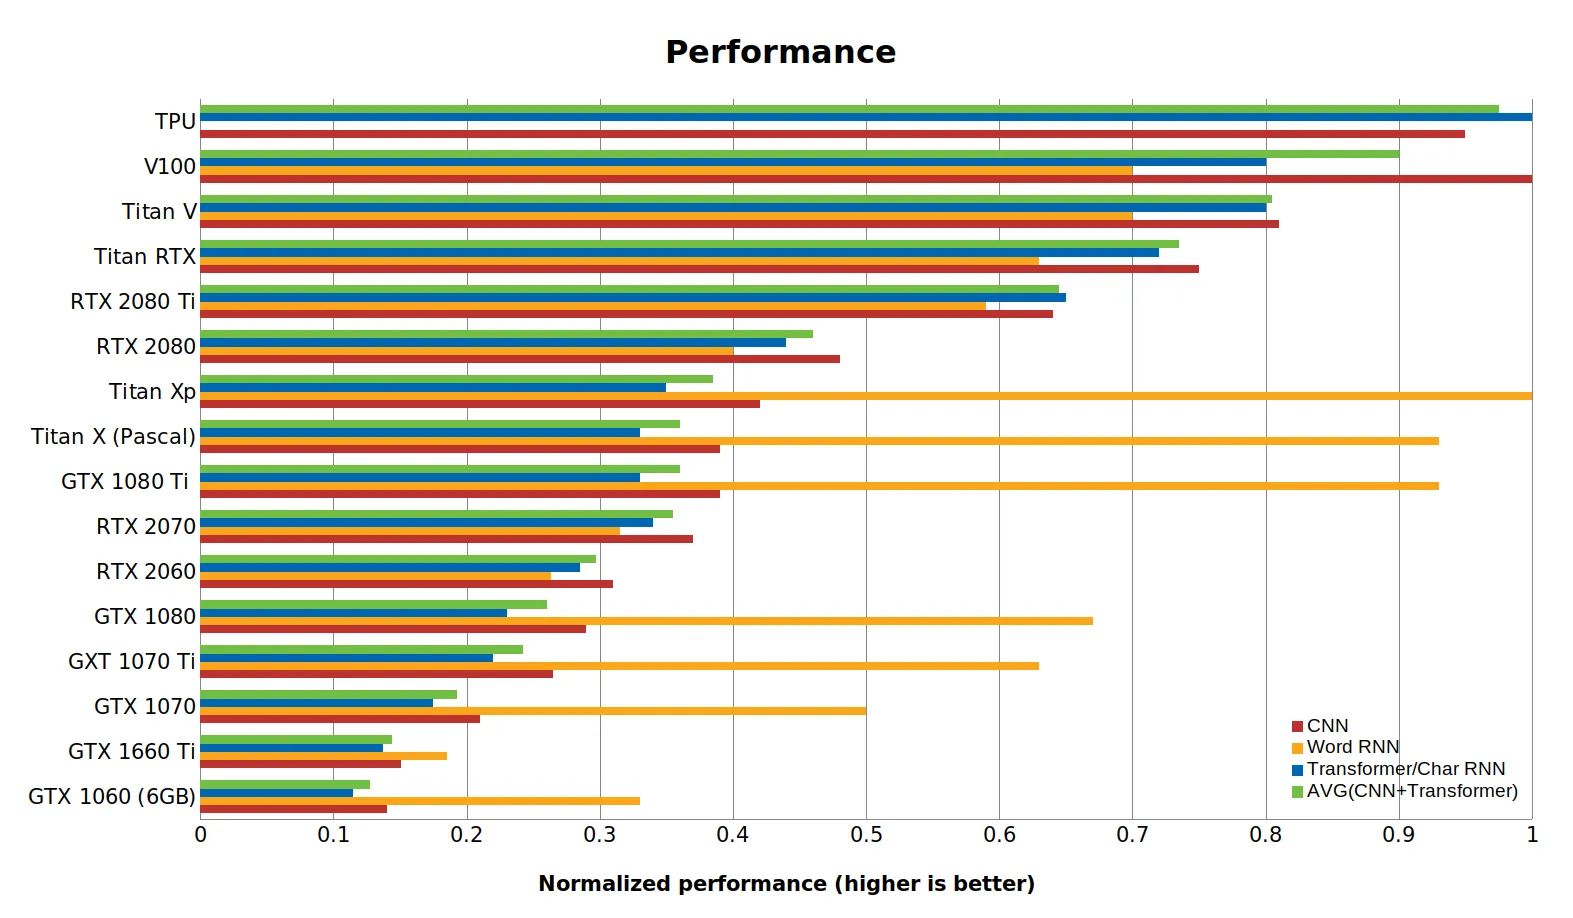

In [1]:
from IPython.display import Image
Image(filename='local/imgs/performance_RTX.png', width=1200)

[Image taken from here](https://timdettmers.com/2019/04/03/which-gpu-for-deep-learning/)